# Linear Regression

In [24]:
import numpy as np

def build_toy_dataset(N, w, noise_std=0.05):
    D = len(w)
    x = np.random.randn(N, D)
    y = np.dot(x, w) + np.random.normal(0, noise_std, size=N)
    return x, y

N = 40  # number of data points
D = 10  # number of features

w_true = np.random.randn(D)
X_train, y_train = build_toy_dataset(N, w_true)
X_test, y_test = build_toy_dataset(N, w_true)

In [29]:
from edward.models import Normal
import edward as ed
import tensorflow as tf

X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(X, w) + b, scale=tf.ones(N))

In [39]:
with tf.variable_scope("qw", reuse=True):
    qw_loc = tf.get_variable("loc", [D])
    qw_scale = tf.get_variable("scale", [D])

    
with tf.variable_scope("qb", reuse=True):
    qb_loc = tf.get_variable('loc', [1])
    qb_scale = tf.get_variable("scale", [1])

    
qw = Normal(loc=qw_loc,
            scale=qw_scale)
qb = Normal(loc=qb_loc,
            scale=qb_scale)

In [40]:
inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

250/250 [100%] ██████████████████████████████ Elapsed: 4s | Loss: 62.171


In [41]:
y_posterior = ed.copy(y, {w: qw, b: qb})

In [42]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_posterior: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_posterior: y_test}))

Mean squared error on test data:
0.0188563
Mean absolute error on test data:
0.121204


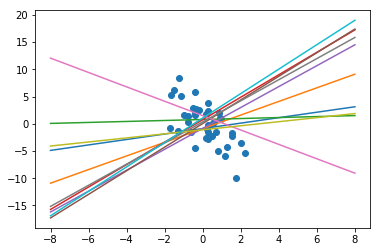

In [44]:
import matplotlib.pyplot as plt

def visualise(X_data, y_data, w, b, n_samples=10):
    w_samples = w.sample(n_samples)[:, 0].eval()
    b_samples = b.sample(n_samples).eval()
    plt.scatter(X_data[:, 0], y_data)
    inputs = np.linspace(-8, 8, num=400)
    for ns in range(n_samples):
        output = inputs * w_samples[ns] + b_samples[ns]
        plt.plot(inputs, output)
    plt.show()
        
visualise(X_train, y_train, w, b)

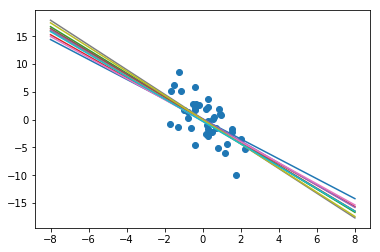

In [45]:
visualise(X_train, y_train, qw, qb)

# Two Layer Bayesian Neural Network

In [17]:
x_train = np.linspace(-3, 3, num=50)
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=50)
x_train = x_train.astype(np.float32).reshape((50,1))
y_train = y_train.astype(np.float32).reshape((50,1))

In [18]:
import tensorflow as tf
from edward.models import Normal

The function $f(x) = y$ can be written as 

\begin{equation}
y_{pred} = (W_{0}^{T}x + b_{0})^{T}W_{1} + b_{1}
\end{equation}

The shapes of the variables are

* $x = \{1,50\}$
* $W_{0} =  \{1,2\}$
* $W_{0}^{T}x =  \{2,50\}$
* $b_0 = \{2\} $
* $W_{0}x + b_0 = \{2,50\}$
* $W_{1} =  \{2,1\}$
* $(W_{0}x + b_0)^{T}W_{1} = \{50,1\}$
* $(W_{0}x + b_0)^{T}W_{1} + b_1 = \{50,1\}$

In [19]:
# initialize W_0 to be a length-2 vector
W_0 = Normal(loc=tf.zeros([1,2]), scale=tf.ones([1,2]))

# initialize W_1 to be a length-2 vector
W_1 = Normal(loc=tf.zeros([2, 1]), scale=tf.ones([2, 1]))

# initialize the first bias to be at locati
b_0 = Normal(loc=tf.zeros(2), scale=tf.ones(2))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

In [20]:
x = x_train

In [21]:
# define the equation for y

y = Normal(loc=tf.matmul(tf.tanh(tf.matmul(x, W_0) + b_0), W_1) + b_1, scale=0.1)

In [22]:
qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [1, 2]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [1, 2])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [2, 1]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [2, 1])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [2]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [2])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [1]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [1])))

In [23]:
import edward

inference = edward.KLqp({W_0: qW_0, b_0: qb_0, W_1: qW_1, b_1: qb_1},
                   data={y: y_train})
inference.run(n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: 40.706
